# Embedding

The following test is designed to test your ability to work with product embeddings.

## Datasets

* **embeddings.txt**: the raw embeddings track embeddings from a Word2Vec model. The first row contains the number of the rows in the file and the dimensionality of the embeddings. For the remaining rows the first item contains the *trackId* and the remaining elements make up the embeddings
    
* **metadata.csv**: metadata for each track in embeddings.txt

## Problem 1: Finding Neighbours

Compute the nearest neighbours for all the tracks (item-to-item recommendations) and examine the nearest neighbours of a few selected tracks using the provided metadata to verify your results. Try to make your solution scalable, some of our models contains millions of items.

### 2.3.1 Read data

In [1]:
filename = "datasets/embeddings.txt"
with open(filename) as f:
    content = f.readlines()

In [2]:
number_of_tracks, dm = content[0].replace('\n','').split(' ')
number_of_tracks = int(number_of_tracks)
dm = int(dm)

In [3]:
import numpy as np
def conv(fld):
    return -float(fld[:-1]) if fld.endswith(b'-') else float(fld)
tracks = np.loadtxt(content[1:], converters={0: conv, 1: conv})

### 2.3.2 Find the k nearest tracks for each track, based on cosine distance

In [4]:
from scipy.spatial.distance import cdist
def find_k_nearest_neighbor(k = 1, tracks = tracks):
    number_of_tracks = len(tracks)
    track = []
    nearest_track = []
    min_distance = []
    for i in range(0,number_of_tracks):
        track.append([int(tracks[i,0])])
        all_distance = cdist(tracks[i:i+1,1:], np.delete(tracks, i, 0)[:,1:], metric='cosine')[0]
        smallest_k = np.argpartition(all_distance,k)[0:k]
        min_distance.append(all_distance[smallest_k])
        for idx in range(0,k):
            if smallest_k[idx] >= i: smallest_k[idx] = smallest_k[idx] + 1
        nearest_track.append(tracks[smallest_k,0])
    return track, nearest_track, min_distance

### 2.3.3 Find the nearest one track for all the tracks

In [5]:
track, nearest_track, min_distance = find_k_nearest_neighbor(k = 1,  tracks = tracks)

In [6]:
from pandas import DataFrame
res_df = DataFrame({'trackId': np.concatenate(track).ravel(), 'nearest_track': np.concatenate(nearest_track).ravel(), 'min_distance': np.concatenate(min_distance).ravel()})

In [7]:
from pandas import read_csv
meta_data = read_csv('datasets/metadata.csv')

In [8]:
from pandas import merge,concat
songs = merge(res_df.iloc[:,0:1], meta_data.iloc[:,[0,1,2,6]],  how='left', left_on=["trackId"], right_on=["trackId"])
neast_songs = merge(res_df.iloc[:,1:2], meta_data.iloc[:,[0,1,2,6]],  how='left', left_on=["nearest_track"], right_on=["trackId"]).iloc[:,1:5].add_prefix('nearest_')
result = concat([songs, neast_songs, res_df.iloc[:,2]], axis=1)

In [9]:
result.head()

,trackId,trackTitle,artistName,genre,nearest_trackId,nearest_trackTitle,nearest_artistName,nearest_genre,min_distance
0,33489248,Formation,Beyoncé,pop,33489281,SORRY,Beyoncé,pop,0.110284
1,33489281,SORRY,Beyoncé,pop,34255906,DON’T HURT YOURSELF,Beyoncé,pop,0.082709
2,41787264,HUMBLE.,Kendrick Lamar,hiphop,42109174,DNA.,Kendrick Lamar,hiphop,0.051593
3,33489283,HOLD UP,Beyoncé,pop,33489275,ALL NIGHT,Beyoncé,pop,0.063340
4,30161031,Ni**as In Paris,JAY-Z,hiphop,30542058,'Till I Collapse,Eminem,hiphop,0.325476


In [10]:
result.to_csv("datasets/nearest_song_results.csv")

## Problem 2: Visualizing Embeddings

Visualizations can be a great tool when working with embeddings. Create some plots that visualizes the embeddings and use them to get a better understanding of the model. What do you think about the quality of the embeddings?

### 2.1: Dimensionality reduction

In [11]:
#dimensionality reduction to 2D
from sklearn.decomposition import PCA
compressed_2D = PCA(random_state=0).fit_transform(tracks[:,1:])[:,:2]



### 2.2 Visualization in 2D mapping

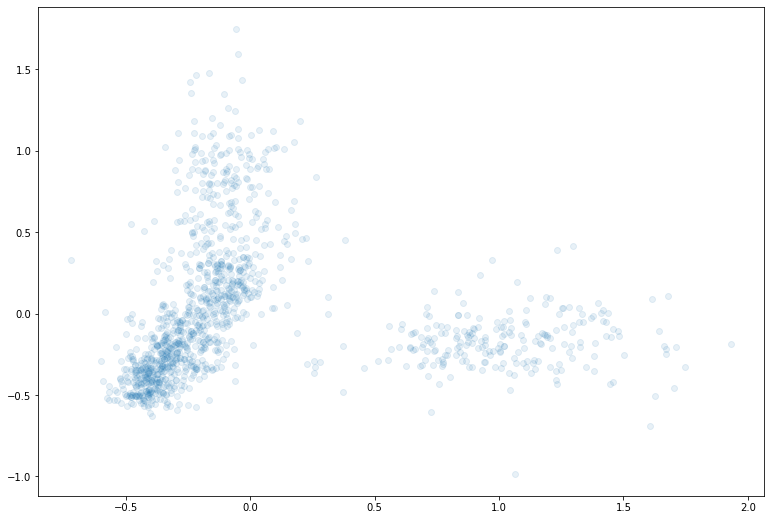

In [12]:
import matplotlib.pyplot as plt
FS = (13,9)
fig, ax = plt.subplots(figsize=FS)
ax.scatter(compressed_2D[:, 0], compressed_2D[:, 1], alpha=.1)

### 2.3 Look into some features

In [13]:
plot_df = DataFrame({"trackId": tracks[:,0],
                     "2d.x": compressed_2D[:, 0], 
                     "2d.y": compressed_2D[:, 1]}).astype({'trackId': 'int32'})

plot_df = merge(plot_df, meta_data,  how='left', left_on=["trackId"], right_on=["trackId"])
plot_df = plot_df.set_index("trackId")
plot_df.head()

,2d.x,2d.y,trackTitle,artistName,albumTitle,releaseDate,popularity,genre
trackId,,,,,,,,
33489248,-0.256952,-0.204639,Formation,Beyoncé,Formation,2016-02-06 00:00:00.000,93.0,pop
33489281,-0.202393,-0.237580,SORRY,Beyoncé,LEMONADE,2016-04-23 00:00:00.000,93.0,pop
41787264,-0.296342,-0.281922,HUMBLE.,Kendrick Lamar,HUMBLE.,2017-03-31 00:00:00.000,88.0,hiphop
33489283,-0.198577,-0.220942,HOLD UP,Beyoncé,LEMONADE,2016-04-23 00:00:00.000,92.0,pop
30161031,-0.334342,-0.330864,Ni**as In Paris,JAY-Z,Watch The Throne,2011-08-08 00:00:00.000,86.0,hiphop


#### 2.3.1 Genre

In [14]:
plot_df['genre'].value_counts()

rock           297
reggae         221
pop            179
blues          163
rnb             85
soul            65
hiphop          51
score           40
metal           40
alternative     35
jazz            10
electro          7
classical        5
world            4
Name: genre, dtype: int64

In [15]:
def plot_bg(bg_alpha=.1, figsize=FS):
    fig, ax = plt.subplots(figsize=figsize)
    X = plot_df['2d.x']
    Y = plot_df['2d.y']
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax

def plot_sub(ax, col, cat, color,alpha=0.3):
    temp = plot_df[(plot_df[col]) == cat]
    ax.scatter(temp['2d.x'], temp['2d.y'], alpha=alpha, color=color, label=cat)
    return ax

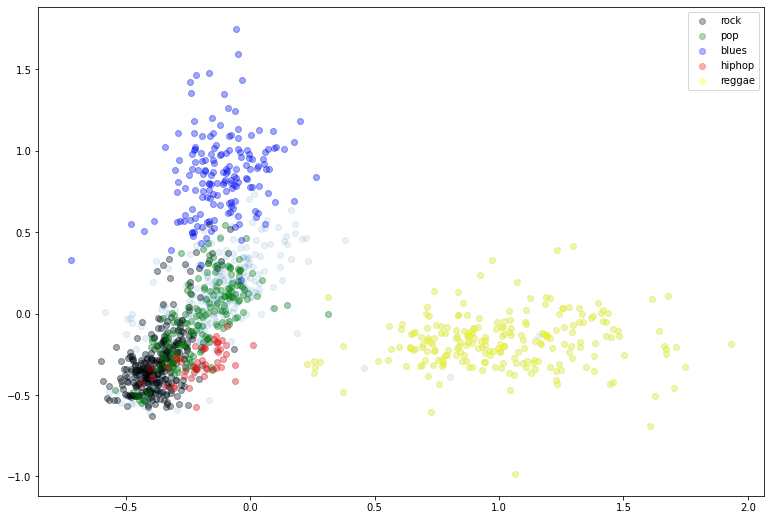

In [16]:
ax = plot_bg(figsize=FS)

colors = ['black','green','blue','red','yellow']
for i,genre in enumerate(['rock','pop','blues','hiphop','reggae']):
    plot_sub(ax, col = 'genre', cat = genre, color = colors[i])
    
ax.legend()



#### 2.3.2 Artists

In [17]:
plot_df['artistName'].value_counts()

The Notorious B.I.G.        5
Bill Withers                5
Junior Kimbrough            5
Magic Slim                  5
Bob Marley & The Wailers    5
                           ..
Ras Michael                 3
Sly and Robbie              2
I-Roy                       1
Tool                        1
Micheal Jackson             1
Name: artistName, Length: 247, dtype: int64

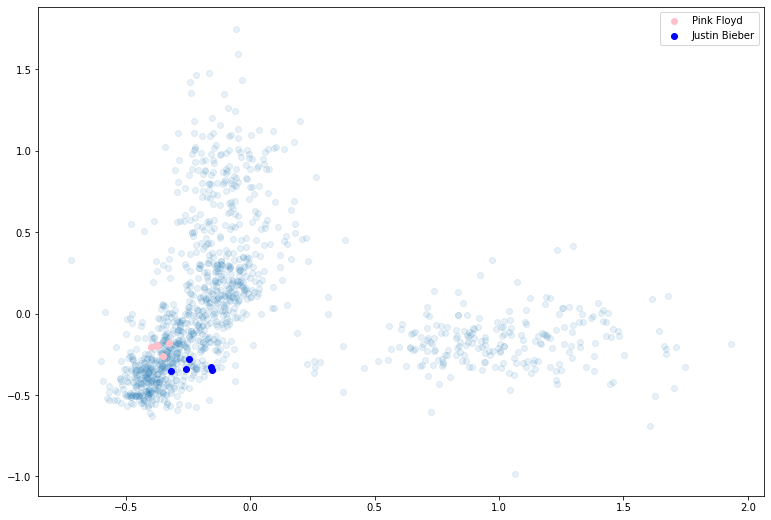

In [18]:
ax = plot_bg(figsize=FS)

colors = ['pink','blue']
for i,artistName in enumerate(['Pink Floyd','Justin Bieber']):
    plot_sub(ax, col = 'artistName', cat = artistName, color = colors[i], alpha = 1)
    
ax.legend()

#### 2.3.3 Year

In [19]:
from datetime import datetime
plot_df['year'] = plot_df['releaseDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').year)
plot_df['year'].value_counts()

2005    75
2003    64
2009    59
2008    57
2015    57
2002    54
2004    54
2001    53
2017    52
2006    48
2000    42
2018    41
2011    41
2013    40
2016    36
2010    35
2007    33
2014    30
1999    30
2012    29
1997    28
1990    27
1996    23
1995    22
1998    21
1992    20
1991    17
1994    15
1993    13
1987     9
1988     8
1984     8
1989     7
1986     5
1971     5
1975     5
1979     5
1982     4
1967     4
1970     3
1976     3
1973     3
1977     2
1969     2
1968     2
1983     2
1960     1
1962     1
1965     1
1978     1
1972     1
1980     1
1981     1
1985     1
1931     1
Name: year, dtype: int64

In [20]:
plot_df['1d'] = PCA(random_state=0).fit_transform(plot_df.iloc[:,0:2])[:,:1] 

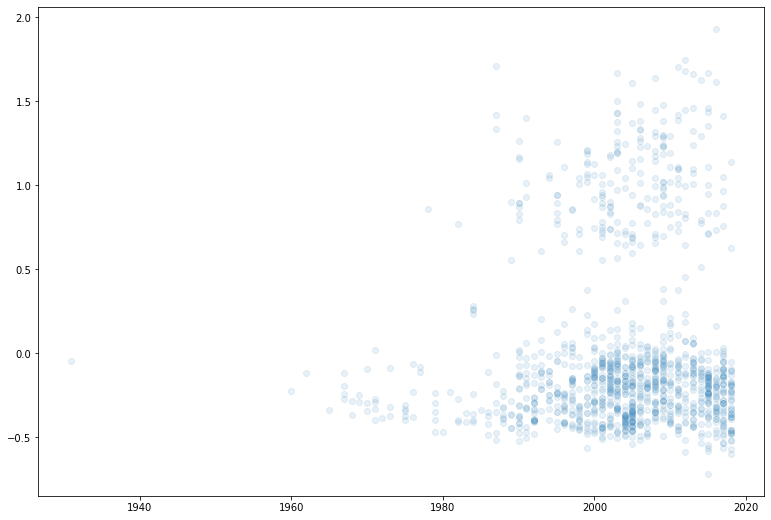

In [21]:
fig, ax = plt.subplots(figsize=(13,9))
X = plot_df['year']
Y = plot_df['1d']
ax.scatter(X, Y, alpha=.1)

### 2.3.4 Popularity

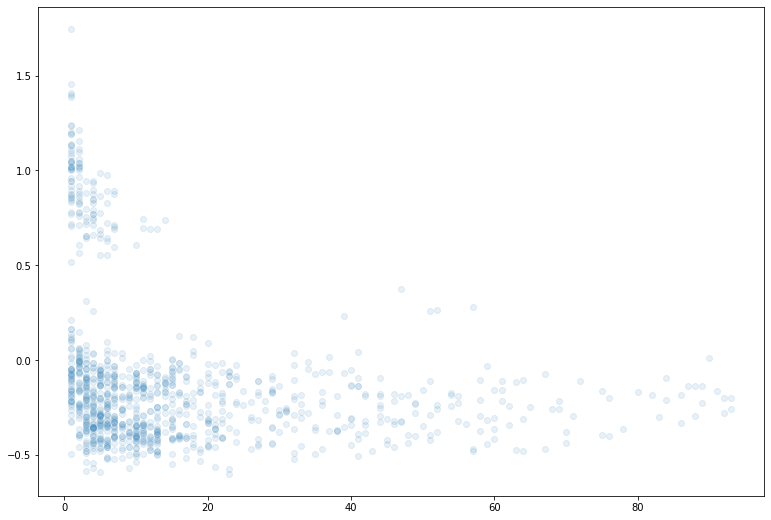

In [22]:
fig, ax = plt.subplots(figsize=(13,9))
X = plot_df['popularity']
Y = plot_df['1d']
ax.scatter(X, Y, alpha=.1)

### 2.4 Quality of embedding

Based on the visualizations above, I believe the quality of embedding could be improved. I expect a better embedding:

 - spreads the dots (which indicate tracks) more evenly in the space
 - seperates pop, rock, and hiphop better
 - gives tracks from Pink Floyd and Justin Bieber larger distance 
 - might be able to reflect the difference in year and popularity etc. better